In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
import sys
import GAE
from pathlib import Path
import torch.nn.functional as F

In [3]:
use_cuda = True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_compare(img1, img2):
    #innormalize
    img1 = img1 / 2 + 0.5
    img2 = img2 / 2 + 0.5
    
    #to_numpy
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(np.transpose(npimg1, (1, 2, 0)))
    axarr[1].imshow(np.transpose(npimg2, (1, 2, 0)))

    plt.show()

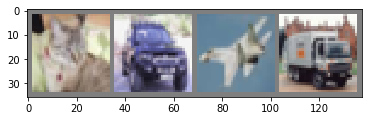

  cat   car plane truck


In [6]:
# get some random training images
dataiter = iter(testloader)
dataiter.next()
dataiter.next()
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
def plotConfidence(TrueConf, AdvConf):
    # data to plot
    n_groups = 10
    Actual = TrueConf.cpu().numpy()
    Adversarial = AdvConf.cpu().numpy()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, Actual, bar_width,
    alpha=opacity,
    color='g',
    label='Actual')

    rects2 = plt.bar(index + bar_width, Adversarial, bar_width,
    alpha=opacity,
    color='r',
    label='Adversarial')

    plt.xlabel('Class')
    plt.ylabel('Confidence')
    plt.title('Confidence of Examples by Model')
    plt.xticks(index + bar_width, classes)
    plt.legend()

    plt.tight_layout()
    plt.show()

def show_conf(actual_pred, fgsm_pred, or_image, per_image):
    actual = torch.sigmoid(actual_pred)*100
    fgsm = torch.sigmoid(fgsm_pred)*100
    imshow_compare(or_image, per_image)
    plotConfidence(actual, fgsm)

def show(i):
    show_conf(original_output[i], perturbed_output[i], images[i], perturbed_image[i])

In [8]:
from GAE.model import Net
model = GAE.model1()
original_output, perturbed_output, perturbed_image = GAE.GenAdv(model, images, 0.01, labels, torch.device('cpu'))

C:\Users\saswa\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\saswa\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\saswa\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute 

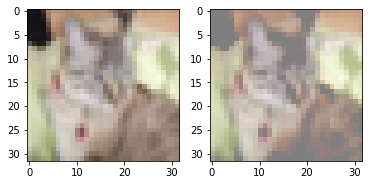

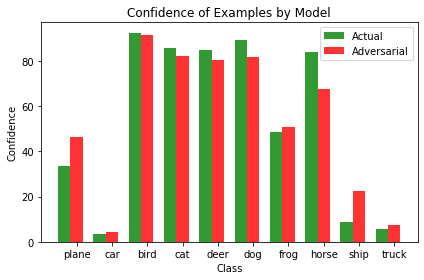

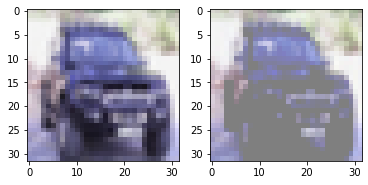

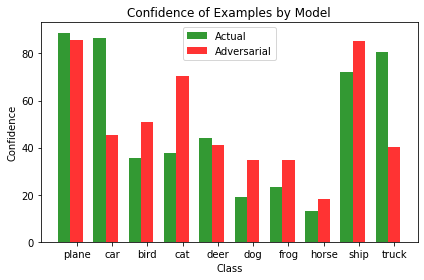

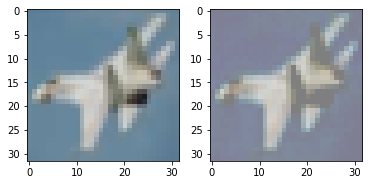

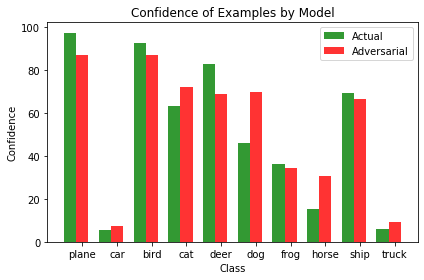

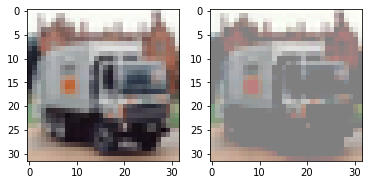

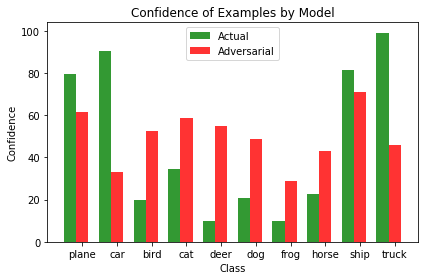

In [12]:
for i in range(images.shape[0]):
    show(i)

In [13]:
#Using Resnet32 pretrained Model
epsilon = 0.01
resnet32 = GAE.pre_resnet32()
original_output, perturbed_output, perturbed_image = GAE.GenAdv(resnet32, images, epsilon, labels, device)

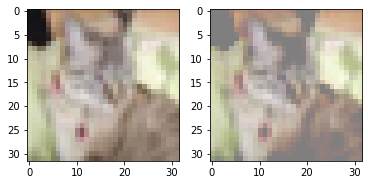

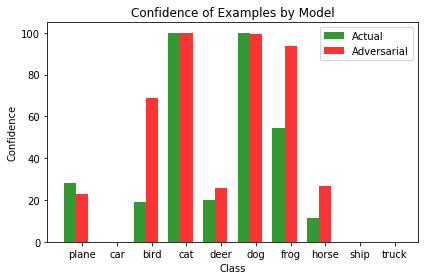

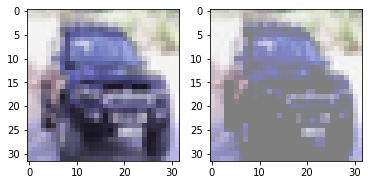

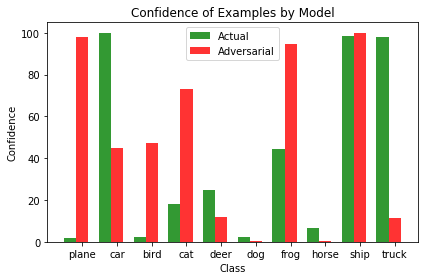

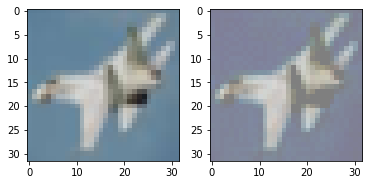

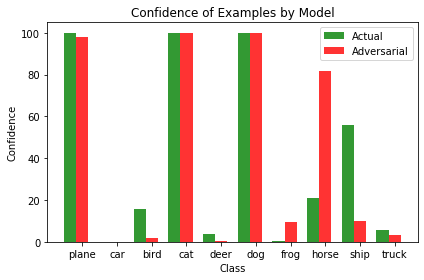

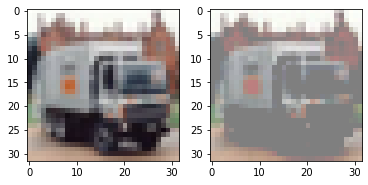

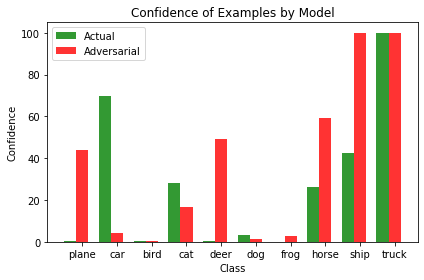

In [14]:
for i in range(images.shape[0]):
    show(i)